# Homework #4: Solution
## EM for Data Augmentation; MCMC Sampling

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2021**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

---

# Problem Description: Latent Variables for Data Augmentation

A botany research lab in Cambridge is exprimentally cross-breeding two types of hibiscus flowers: blue and pink. The goal is to study the genetic factor that creates an exotic flower whose petals are pink with a ring of blue on each. 

There are four types of child plant that can result from this cross-breeding: 

  - Type 1: blue petals
  - Type 2: pink petals 
  - Type 3: purple petals
  - Type 4: pink petals with a blue ring on each. 

Out of 197 initial cross-breedings, the nursery obtained the following counts of the four types of child plants:

$$Y = (y_1, y_2, y_3, y_4) = (125, 18, 20, 34)$$

where $y_i$ represents the number of child plants that are of type $i$.

The geneticist in the lab know that the probability of obtaining each type of child plant in any single breeding experiment is correlated by the inheritability $\theta$ of a specific genetic factor. That is, the probabilities of obtaining the four subtypes are as follows:

$$ \frac{\theta+2}{4}, \frac{1-\theta}{4}, \frac{1-\theta}{4}, \frac{\theta}{4},$$

where $\theta \in [0, 1]$ is unknown.

The lab chose to model the observed data using a multinomial model:

\begin{align}
Y & \sim Mult\left(197, \left[\frac{\theta+2}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{align}

The aim of this problem is to estimate $\theta$ from the observed counts.

## Part I: MLE Through Latent Variable Augmentation and EM
In models where directly computing the MLE is hard (you can think about if that is the case here), the optimization of the likelihood can often be simplified by introducing a latent variable into the model and then optimize the liklelihood using EM - this process is called ***data augmentation***.

The nursery augmented the data with a new variable $Z$ such that:
$$Z + (y_1 - Z) = y_1.$$
That is, using $Z$, they are breaking $y_1$, the number of Type I child plants, into two subtypes, with $Z$ being the count of Subtype #1 and $(y_1-Z)$ being the count of Subtype #2. The lab posited the probability of obtain the two subtype be $\theta/4$ and $1/2$, respectively.

The augmented model (which includes the observed data $y$ and the latent variable $z$ they introduced) they derived is as follows:

\begin{aligned}
Z | Y, \theta &\sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)\\
Y & \sim Mult\left(197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
\end{aligned}

1. Show that the assumptions the lab made about $Z$ implies that $Z | Y, \theta \sim Bin\left(y_1, \frac{\theta}{2 + \theta}\right)$.<br><br>

2. Derive the EM updates for the augmented latent variable model.<br><br>

3. Implement the EM algorithm to estimate the MLE of $\theta$. Choose an appropriate initialization point and an appropriate stopping condition.<br><br>

**Solution:**
### Problem 1
The probability of a child plant of Type $I$ is $\frac{1}{2} + \frac{\theta}{4} = \frac{\theta+2}{4}$. Thus, the probability of obtaining Subtype #1 **given that we have a child plant of Type I** is $\frac{\theta/4}{(\theta + 2)/4} = \frac{\theta}{\theta + 2}$. 

### Problem 2
Recall that the maximum (log) likelihood estimate of $\theta$ is defined as:

$$
\theta_{\text{MLE}} = \underset{\theta}{\text{argmax}} \log p(Y|\theta)
$$

If this is a quantity we cannot or do not wish to directly compute (if, for example, the derivative of the log likelihood is complicated ), then we can maximize a lower bound to the log-likelihood: the ELBO. To emphasize again: **maximizing the ELBO does not maximize the log-likelihood, but it guarantees that your likelihood will be as big as the ELBO**. This is a **trade-off** we explicitly make: tractability of computation for the extent to which log likleihood is maximized.

Recall that the ELBO is defined as 

$$
    ELBO(\theta, q) = \mathbb{E}_{z\sim q(Z)}\left[ \frac{p(Z, Y|\theta)}{q(Z)}\right].
$$

EM is an algorithem in which we iteratively increase the ELBO by coordinate ascent, that is, we maximize the ELBO with respect to $\theta$ while holding $q$ fixed and then maximize $q$ holding $\theta$ fixed:

1. (E-step) $q^*(Z) = \underset{q}{\text{argmax}}\; ELBO(\theta, q) = p(Z|Y, \theta_{old})$

2. (M-step) $\theta^* = \underset{\theta}{\text{argmax}}\; ELBO(\theta, q^*) = \underset{\theta}{\text{argmax}}\;\mathbb{E}_{Z\sim p(Z|Y, \theta_{old})}\left[ \log (p(Y, Z|\theta))\right]$.


For the E-step, since we are given that $p(Z|Y, \theta_{old}) = Bin\left(Z; y_1, \frac{\theta}{2 + \theta}\right)$, there is nothing to compute!

For the M-step, we first compute the expectation $\mathbb{E}_{Z\sim p(Z|Y, \theta_{old})}\left[ \log (p(Y, Z|\theta))\right]$. For this we note that the joint distribution $p(Y, Z|\theta)$ is

$$
p(y, z | \theta) = Bin\left(z; y_1, \frac{\theta}{2 + \theta}\right)Mult\left(y; 197, \left[\frac{1}{2} + \frac{\theta}{4}, \frac{1 - \theta}{4}, \frac{1 - \theta}{4}, \frac{\theta}{4} \right]\right)
$$



Thus, we can rewrite the above expecation (during this process, make note of terms that do not depend on $\theta$, those will be dropped during the optimization step):

\begin{align}
\mathbb{E}_{Z | Y, \theta_{old}}\left[\log p(Y, Z | \theta) \right] =&\; \mathbb{E}_{Z | Y, \theta_{old}}\left[\log\left( \binom{y_{1}}{Z} \left (\frac{1}{2} \right )^{y_1-Z} \left(\frac{\theta}{4} \right )^{Z}  \left(\frac{1-\theta}{4}\right)^{y_2+y_3}  \, \left(\frac{\theta}{4}\right)^{y_4}\right)\right]\\
=&\; \mathbb{E}_{Z | Y, \theta_{old}}\left[  \log\binom{y_1}{Z} +  (y_1 - Z)\log\left(\frac{1}{2}\right)  + Z\log \left(\frac{\theta}{4}\right) +  (y_2 + y_3) \log \left(\frac{1-\theta}{4}\right) + y_4 \log \left(\frac{\theta}{4}\right) \right]\\
=&\;  \mathbb{E}_{Z | Y, \theta_{old}\theta}\left[\log\binom{y_1}{Z}\right] +   \log\left(\frac{1}{2}\right)\mathbb{E}_{Z | Y, \theta_{old}} (y_1 - Z)  + \log (\theta)\;\mathbb{E}_{Z | Y, \theta_{old}} \left[Z\right] +  (y_2 + y_3) \log \left({1-\theta}\right)+ y_4 \log \left({\theta}\right) - 3\log 4 \\
=&\; \mathbb{E}_{Z | Y, \theta_{old}}\left[\log\binom{y_1}{Z}\right]  +  \log\left(\frac{1}{2}\right) \left(y_1 - \frac{y_1\theta_{old}}{2 + \theta_{old}}\right)  + \log (\theta)\left(\frac{y_1\theta_{old}}{2 + \theta_{old}}\right) +  (y_2 + y_3) \log (1 - \theta) + y_4\log (\theta) - 3\log 4\\
=&\;  C + \log (\theta)\left(\frac{y_1\theta_{old}}{2 + \theta_{old}}\right) +  (y_2 + y_3 ) \log (1 - \theta) + y_4 \log (\theta)\\
\end{align}

where $C = \mathbb{E}_{Z | Y, \theta}\left[\log\binom{y_1}{Z}\right] + \log\frac{1}{2} \left(y_1 - \frac{y_1\theta_{old}}{2 + \theta_{old}}\right)  - 3\log 4$ are all the terms that do not involve $\theta$.

To complete the M-step, we maximize the above with respect to $\theta$, and thus can drop any terms not involving $\theta$:

\begin{align}
\underset{\theta}{\text{argmax}} \left[ C   +  (y_2 + y_3) \log (1 - \theta) + \left(y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}\right) \log\theta\right] = \underset{\theta}{\text{argmax}}\left[(y_2 + y_3) \log (1 - \theta) + \left(y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}\right) \log\theta\right]
\end{align}

But the above looks like (up to a constant) the log likelihood of a binomial pdf! That is,

\begin{align}
\underset{\theta}{\text{argmax}}\left[(y_2 + y_3) \log (1 - \theta) + \left(y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}\right) \log\theta\right] & =\underset{\theta}{\text{argmax}}\left[(y_2 + y_3) \log (1 - \theta) + \left(y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}\right) \log\theta + \log \mathcal{Z}\right]\\
&=  \text{argmax}_\theta \log Bin\left(B; A + B, \theta  \right)
\end{align}

where $A = y_2 + y_3$ and $B = y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}$ and $\mathcal{Z}$ is the normalizing constant of the binomial. So $\underset{\theta}{\text{argmax}}$ of the above is just taking the MLE of a binomial. But the MLE of this binomial is 
$$
\frac{B}{A + B} = \frac{ y_4  + \frac{y_1\theta_{old}}{2 + \theta^{t-1}}}{ y_2 + y_3 + y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}}.
$$

So the in the M-Step, we get that
$$
\theta^* = \frac{ y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}}{ y_2 + y_3 + y_4  + \frac{y_1\theta_{old}}{2 + \theta_{old}}}.
$$

### Problem 3
We implement the two steps in EM and run the algorithm for until convergence or up to 1000 iterations.

In [2]:
#convergence threshold for theta
conv_thresh = 1e-9
#total iterations
total_iters = 1000
#initial difference between current and new theta
diff = 1.
#counts
y = (125,18,20,34)
#initialize theta at 1.
thetas = [1.]
#initialize iteration number at 0
i = 0

#while convergence threshold is not reached or under the total number of iterations
while i < total_iters and diff > conv_thresh:
    #update for theta from the M-step
    theta = ((y[0] * thetas[-1])/(2 + thetas[-1]) + y[3])/((y[0] * thetas[-1])/(2 + thetas[-1]) + y[3] + y[2] + y[1])
    print('iteration {}, theta {}'.format(i, theta))
    #update iteration counter
    i += 1
    #compute different between current theta and new theta
    diff = abs(theta - thetas[-1])
    #add the new theta to our list of theta estimates
    thetas.append(theta)
    
print('final estimate of MLE of theta', thetas[-1])

iteration 0, theta 0.6656891495601173
iteration 1, theta 0.6318386749517709
iteration 2, theta 0.6274852197611572
iteration 3, theta 0.6269095829647825
iteration 4, theta 0.6268331929394925
iteration 5, theta 0.6268230507139951
iteration 6, theta 0.6268217040552755
iteration 7, theta 0.6268215252478676
iteration 8, theta 0.6268215015060504
iteration 9, theta 0.6268214983536422
iteration 10, theta 0.6268214979350694
final estimate of MLE of theta 0.6268214979350694


It looks like EM converged in 10 iterations!

The key in this problem was that we introduced the latent variable in order to break up the observed likelihood (the likelihood of $Y$) into two parts: terms that involve $\theta$, $1 - \theta$, which can be combined into a binomial likelihood, and terms that involve only the latent variable, which is later integrate out when we take the expectation. Applying EM in this case essentially ensures that we only perform optimization on simplified objectives.

In this problem, you might have directly optimized the original likelihood $\log p(y)$ by taking the gradient, setting it equal to zero and analytically solving for the zeros. However, this will be more complicated than optimizing a multinomial where each component of the multinomial parameters are independent -- in our case, $\theta$ appears in all four components of the probability parameter of the multinomial. Optimizing $\log p(y)$ using EM means that ***instead of analytically solving for the global optimum, we algorithmically find this optimum***, and this has many advantages where the analytically solving for the global optimum is too difficult.

This is a toy example of a broad class of related methods:
[The Art of Data Augmentation](http://www.stat.harvard.edu/Faculty_Content/meng/JCGS01.pdf)

---

# Problem Description: Modeling Kidney Cancer Data
In this problem, we will work with the US Kidney Cancer Data set, `kcancer.csv`. This is a dataset of kidney cancer frequencies across the US over 5 years on a per county basis. 

**In this homework, we focus on the mechanics of seting up a statistical model for this data set and performing inference on it. In the next homework, we will focus on interpreting this model and comparing it with others in context.**

Let $N$ be the number of counties; let $y_j$ the number of kidney cancer case for the $j$-th county, $n_j$ the population of the $j$-county and $\theta_j$ be the underlying kidney cancer rate for that county. The following is a Bayesian model for our data:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Gamma(\alpha, \beta), \quad j = 1, \ldots, N
\end{aligned}

where $\alpha, \beta$ are hyper-parameters of the model.


Rather than arbitrarily choosing the hyperparameters $\alpha, \beta$, following the Bayesian philosophy, we typically put additional priors on quantities of which we are uncertain. That is, we model the kidney cancer rates using a ***hierarchical model***:

\begin{aligned}
y_j &\sim Poisson(5 \cdot n_j \cdot \theta_j), \quad j = 1, \ldots, N\\
\theta_j &\sim Ga(\alpha, \beta), \quad j = 1, \ldots, N\\
\alpha &\sim Ga(a, b)\\
\beta &\sim Ga(c, d)
\end{aligned}
where $a, b, c, d$ are hyperparameters. 

In this problem, you will implement a modified Gibbs sampler to sample from the posterior of this complex model.

## Part I: The Conditional Distributions
1. Justify our choice to use a hierarchical model. Specifically, explain the draw-backs of using MLE estimates of $\theta_j$ to represent the underlying cancer rates of these counties (recall the discussion in Lecture #3). Explain the draw-backs of choosing specific values for the hyper-parameters of $\alpha$ and $\beta$ rather than putting priors on them (recall the discussion in Homework #1 about priors).<br><br>

2. Verify that the conditional distributions are 
\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &= Ga(\theta_j; \alpha + y_j, 5 n_j  + \beta),\\
p(\alpha, \beta | \theta, y) &\propto \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}
\end{align}
  where we use the following notation:
\begin{align}
\theta &:= \{ \theta_j\}_{j=1, \ldots, N}\\
\theta_{-j} &:= \{ \theta_j\}_{j=1, , \ldots,j-1, j+1,\ldots, N}\\
y &:= \{y_j \}_{j=1, \ldots, N}\\
y_{-j} &:= \{ y_j\}_{j=1,, \ldots, j-1, j+1,\ldots, N}\\
\end{align}
  Unfortunately, you see that $p(\alpha, \beta | \theta, y)$ doesn't resemble the pdf of a nice simple distribution; that is, it is unclear how to sample from it.
  
**Solutions:**  
  
  
### Problem 1.

As we discussed in class, the MLE to represent cancer rates exagerates rate (either higher or lower than they ought to be) when the population in the county is small. The issue with a simple Bayesian model is that the posterior can be highly sensitive to the choice of prior, again, when the number of observations is small (see HW #1 solutions), i.e. when the populations of the county is small priors can add a lot of bias! Right now, our justification for adding the gamma ***hyper priors*** to the model is to mitigate the effect of the choice of prior on the posterior. In Lecture #9, we discuss another advantage of choosing a hierarchical model.


### Problem 2.

The joint distribution of the variables in our hierarchical model is

$$
p(\theta, y, \alpha, \beta) = \prod_j \left(Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\right)Gamma(a, b)Gamma(c, d).
$$

Note that, with respect to $\theta_j$, every term involving $\theta_k$ where $k\neq j$ is a constant.
Thus, $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ can be written

\begin{align}
p(\theta_j | \theta_{-j}, y, \alpha, \beta) &\propto Poisson(y_j; 5 \cdot n_j \cdot \theta_j) Gamma(\theta_j; \alpha, \beta)\\
&= Gamma(\theta_j; \alpha + y_j, 5 n_j  + \beta),
\end{align}
Here we're using again the fact that $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ is a pdf so if the non-constant terms of $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ match those of a Gamma distribution, then the normalizing constant of $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$ has to be that of the Gamma.

and $p(\alpha, \beta | \theta, y)$ (again treating all terms not containing $\alpha$ and $\beta$ as constants) can be written

\begin{align}
p(\alpha, \beta | \theta, y) &\propto \left[\prod_j Gamma(\theta_j; \alpha, \beta)\right] Gamma(a, b)Gamma(c, d)\\
&\propto \prod_j \left[\frac{\beta^\alpha}{\Gamma(\alpha)} \theta_j^{\alpha - 1} e^{-\beta\theta_j}\right] \alpha^{a-1} e^{-b\alpha} \beta^{c-1} e^{-d\beta}\\
&= \frac{\beta^{N\alpha}}{\Gamma^N(\alpha)} \left[\prod_j \theta_j^{\alpha - 1}\right] e^{-\sum_j\beta\theta_j - d\beta - b\alpha} \alpha^{a-1} \beta^{c-1}.
\end{align}

## Part II: Metropolis-Hastings-in-Gibbs
1. When one or more conditional distributions in a Gibbs sampler do not have closed forms (this is the case for most models), we often sample from these conditionals using another MCMC method (e.g. Metropolis Hastings). That is, we modify the Gibbs sampler as follows:

  **I.** Sample $\theta_j$ using the closed form for $p(\theta_j | \theta_{-j}, y, \alpha, \beta)$.
  
  **II.** Sample $\alpha, \beta$ from $p(\alpha, \beta | \theta, y)$ using a Metropolis-Hastings step (i.e. use a proposal distribution to propose a sample and the MH reject/accept mechanism to accept the new sample or keep the old).
  
  This algorithm is called a ***Metropolis-Hastings-in-Gibbs sampler***.

  Note that we computed $p(\alpha, \beta | \theta, y)$ only up to a constant. Show why we don't need to know the normalizing constant of $p(\alpha, \beta | \theta, y)$ when we perform MH sampling.<br><br>
  
2.  Implement and run a Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

  We suggest the following settings for your MH-in-Gibbs sampler, but please feel free to use your own:
  
  - Gibbs sweeps: 100,000
  - $a = 9, b = 6, c = 9, d = 0.00001$
  - Starting points: $\alpha_0 = 1.54517349188, \beta_0 = 133514.171939$
  - proposal distribution: $\mathcal{N}\left([\alpha, \beta], \left[\begin{array}{cc} 0.1 & 0 \\ 0 & 1000\end{array}\right]\right)$
  - burn in: 10%
  - thinning: 10<br><br>
  
3. Check for and discuss the convergence of your sampler. If you think your sampler has converged, explain why. If you believe your sampler has not converged, explain what next steps you might take to determine which design choices were problemmatic.
  
  **Important Disclaimer:** Convergence in a untweaked sampler may be unlikely after only 100,000 Gibbs sweeps. We are not asking you in this homework to achieve convergence, but you must demonstrate that you know how to perform diagnostics on your sampler.<br><br>
  
 

**Solutions:**

### Problem 1
Note that the acceptance probability of the Metropolis-Hastings algorithm is defined as

$$
\min \left(1, \frac{p(\theta_{\text{prop}}) / q(\theta_{\text{prop}} | \theta_{\text{old}})}{p(\theta_{\text{old}})/ q(\theta_{\text{old}} | \theta_{\text{prop}})} \right).
$$

At a first glance it looks like we need to evaluate the pdf $p$. However, consider the case where we only know $p$ up to a constant. That is, we have a function $\tilde{p} = p/\mathcal{Z}$, where $\mathcal{Z}$ is a constant. Then the acceptance probability can be written:

$$
\min \left(1, \frac{\mathcal{Z}\tilde{p}(\theta_{\text{prop}}) / q(\theta_{\text{prop}} | \theta_{\text{old}})}{\mathcal{Z}\tilde{p}(\theta_{\text{old}})/ q(\theta_{\text{old}} | \theta_{\text{prop}})} \right) = \min \left(1, \frac{\tilde{p}(\theta_{\text{prop}}) / q(\theta_{\text{prop}} | \theta_{\text{old}})}{\tilde{p}(\theta_{\text{old}})/ q(\theta_{\text{old}} | \theta_{\text{prop}})} \right).
$$

That is, we only need to know the target distribution $p$ up to a constant. In particular, this means that for posteriors whose normalizing constant we can't compute, we can still apply MH sampling!

### Problem 2

We implement Metropolis-Hastings-in-Gibbs sampler for the kidney cancer model.

In [3]:
#function for sampling a pair (alpha, beta) using Metropolis-Hastings
def draw_alpha_beta(alpha, beta, y, theta, steps):
    #initialization 
    old_alpha = alpha
    old_beta = beta
    accept = 0
    
    for step in range(steps):
        #propose a pair (alpha, beta)
        new_alpha, new_beta = np.random.multivariate_normal([old_alpha, old_beta], [[sigma_alpha, 0], [0, sigma_beta]], 1)[0]
        #compute the log of the ratio of pdf's evaluated at the new and old alpha, beta values
        log_accept_frac = p_alpha_beta(new_alpha, new_beta, theta) - p_alpha_beta(old_alpha, old_beta, theta)
        #Accept mechanism
        if np.log(np.random.uniform()) < log_accept_frac:
            old_alpha = new_alpha
            old_beta = new_beta
            accept += 1
            
    return old_alpha, old_beta, accept * 1. / steps
    
#gibbs Sampling
def gibbs(y, n, alpha_init, beta_init, theta_init, iters, burn, thin=1):   
    #initialization 
    alphas = [alpha_init]
    betas = [beta_init]
    theta = theta_init
    accept_alpha_beta = 0
    samples = [theta]
    
    
    for i in range(iters):
            
        #draw alpha, beta
        alpha, beta, accept = draw_alpha_beta(alphas[-1], betas[-1], y, theta, 1)
        alphas.append(alpha)
        betas.append(beta)
        
        accept_alpha_beta += accept
        
        if (i % 5000 == 0) and i > 0:
            print('iteration {}, accept rate for MH {}'.format(i, accept_alpha_beta * 1. / i))

        #draw theta
        theta = draw_theta(y, n, alphas[-1], betas[-1])
        samples.append(theta)
        
    return np.array(samples[int(burn * iters)::thin]), accept_alpha_beta / iters, alphas[int(burn * iters)::thin], betas[int(burn * iters)::thin]

In [5]:
df = pd.read_csv('kcancer.csv')

#set hyperparameters
a = 9
b = 6
c = 9
d = 0.00001
sigma_alpha = 0.1
sigma_beta = 1000

#set observed variables
N = len(df)
n = df['pop'].values
y = df['dc'].values

#Function for sampling a theta for a particular county
draw_theta = lambda y_j, n_j, alpha, beta: np.random.gamma(y_j + alpha, scale=1. / (5. *  n_j + beta))

#The joint pdf of alpha and beta
p_alpha_beta = lambda alpha, beta, theta: np.log(sp.stats.gamma.pdf(alpha, a, scale=1. / b)) \
                                          + np.log(sp.stats.gamma.pdf(beta, c, scale=1. / d)) \
                                          + (alpha - 1)* np.log(theta).sum() - beta * theta.sum() \
                                          + N * alpha * np.log(beta) \
                                          - N * np.log(sp.special.gamma(alpha))                 

In [6]:
#Initialize all parameters
alpha_init = 1.54517349188
beta_init = 133514.171939
theta_init = draw_theta(y, n, alpha_init, beta_init)

#Sample 100,000 samples with burn-in of 20% and thinning of 2
iters = 100000
thin = 20
burn = 0.2
samples, accept_rate, alphas, betas = gibbs(y, n, alpha_init, beta_init, theta_init, iters, burn, thin=thin)
print('\n\nAccept rate of M-H step:', accept_rate)

iteration 5000, accept rate for MH 0.0808
iteration 10000, accept rate for MH 0.0848
iteration 15000, accept rate for MH 0.0848
iteration 20000, accept rate for MH 0.08375
iteration 25000, accept rate for MH 0.08512
iteration 30000, accept rate for MH 0.0862
iteration 35000, accept rate for MH 0.08608571428571428
iteration 40000, accept rate for MH 0.0866
iteration 45000, accept rate for MH 0.08613333333333334
iteration 50000, accept rate for MH 0.08608
iteration 55000, accept rate for MH 0.0856909090909091
iteration 60000, accept rate for MH 0.08646666666666666
iteration 65000, accept rate for MH 0.08630769230769231
iteration 70000, accept rate for MH 0.08677142857142857
iteration 75000, accept rate for MH 0.087
iteration 80000, accept rate for MH 0.0869625
iteration 85000, accept rate for MH 0.08730588235294118
iteration 90000, accept rate for MH 0.08682222222222222
iteration 95000, accept rate for MH 0.08694736842105263


Accept rate of M-H step: 0.08647


### Problem 3
We see that the over all acceptance rate for the MH step is very low, this means that our sampler may converge very slowly -- i.e. after 100,000 sweeps it mayb not yet be converged!

We can check for signs of failure to converge by examining the traceplots for some of the paramters.

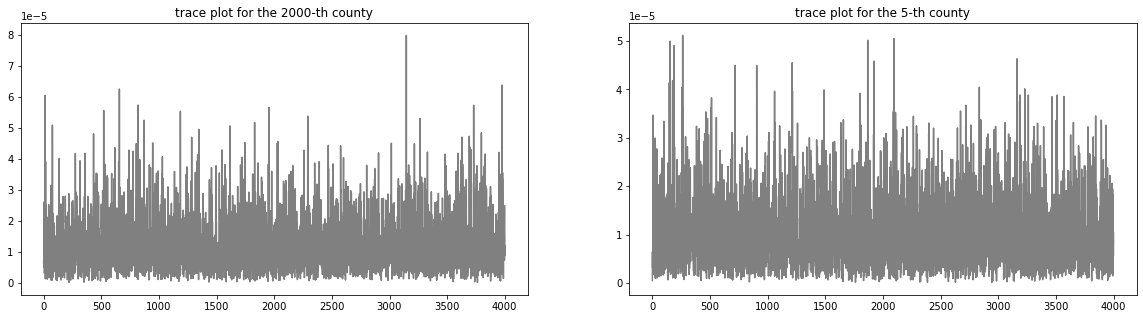

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
county_number = 2000
theta_conv_check = samples[:, county_number]
ax[0].plot(range(len(theta_conv_check)), theta_conv_check, color='gray')
ax[0].set_title('trace plot for the {}-th county'.format(county_number))

county_number = 5
theta_conv_check = samples[:, county_number]
ax[1].plot(range(len(theta_conv_check)), theta_conv_check, color='gray')
ax[1].set_title('trace plot for the {}-th county'.format(county_number))
plt.show()

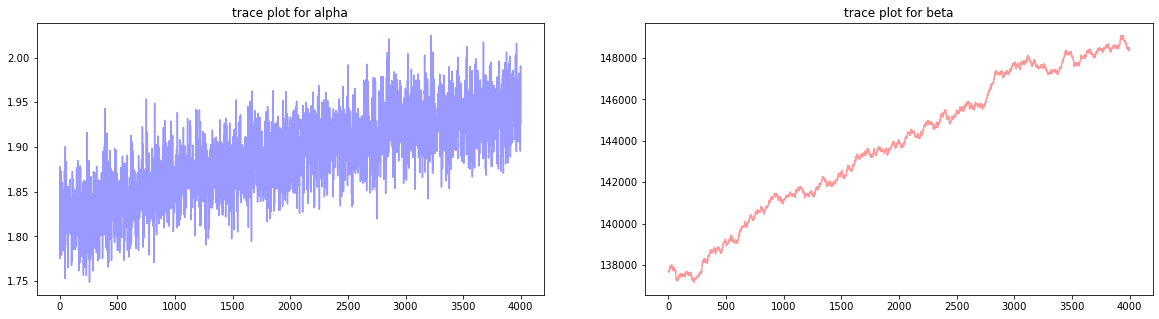

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
theta_conv_check = samples[:, county_number]
ax[0].plot(range(len(alphas)), alphas, color='blue', alpha=0.4)
ax[0].set_title('trace plot for alpha')

theta_conv_check = samples[:, county_number]
ax[1].plot(range(len(betas)), betas, color='red', alpha=0.4)
ax[1].set_title('trace plot for beta')
plt.show()

It looks like from the trace plots that the $\theta$'s **might** have converged (remember always the danger of drawing conclusions about convergence using traceplots! Recall the bimodal example from Lecture #6).

But certainly it looks like $\alpha$ and $\beta$ have not converged. The samples for $\beta$ in particular look like they are tending towards a higher mass region. This is also indicated by the low acceptance rate of the MH sampler that produced these samples of $\alpha$ and $\beta$.

Now, to simplify the amount of derivations we had to do, we made an earlier choice to jointly sample $\alpha$ and $\beta$. But since the values of $\beta$ are so large, it tends to dominate in the ratio of pdf's. One way to improve our sampler may be to sample $\alpha$ and $\beta$ separately (some of you have made this modification with successful results). Other changes one can make include changing the proposal distribution and the settings of the hyperparameters.

## Part III: Broader Impact Analysis

Starting in 2020, major machine learning conferences are beginning to ask authors as well as reviewers to explicitly consider the broader impact of new machine learning methods. To properly evaluate the potential good or harm that a piece of technology (AI or not) can do to the general public, we need to be aware that no technology is deployed in ideal conditions or in perfectly neutral contexts. In order to assess the potential broader impact of technology, we need to analyze the social systems/institutions of which these technologies will become a part.

To help you analyze the broader impact of your technology, begin by considering the following questions:

I. Identify the relevant socio-technical systems
  - In what social, political, economic system could the tech be deployed?
  - How would the tech be used in these systems (what role will it take in the decision making processes)?<br><br>
  
II. Identify the stakeholders
  - Who are the users?
  - Who are the affected communities (are these the users)?
  
    ***Hint:*** users are typically decision makers who will use the technology as decision aids (e.g. doctors), whereas affected communities may be folks who are impacted by these decisions but who are not represented in the decision making process (e.g. patients).<br><br>
    
III. What types of harm can this tech do?
  - What kinds of failures can this tech have?
  - What kinds of direct harm can these failures cause?
  - What kinds of harm can the socio-technical system cause?
  
    ***Hint:*** many technical innovations have niche applications, they may sit in a long chain of decision making in a complex system. As such, it may seem, at first glance, that these technologies have no immediate real-life impact. In these cases, it’s helpful to think about the impact of the entire system and then think about how the proposed innovations aid, hamper or change the goals or outcomes of this system.<br><br>
    
IV. What types of good can this tech do?
  - What kinds of needs do these users/communities have?
  - What kinds of constraints do these users/communities have?
  
1. **(Impact)**  Analyze the broader impact of this model for kidney cancer. Focus on anticipating ways these models can interact with other components of the decision systems in which they will be deployed, identifying end-users, affected communities as well as anticipating the effects (positive and negative) on affected communities (in particular, does the model have the same effect on all subpopulations in the affected communities?). 

  In terms of broader impact, is it more preferable to use a hiearchical model, an MLE model or a Bayesian model with hand-picked priors for this dataset? Previously, we have outlined the advantages of hierarchical models over the other two types of models. Under what circumstances would using a hierarchical model to model the data have potentially negative impact on down-stream decision making?
  
**Solutions:** When writing this broader impact statement you should reference our in-class discussion:
1. What are some mathematical drawbacks of MLE vs Bayesian with arbitrary priors vs Hierarchical Bayes? For example, 
  - MLE models can overfit on counties with small populations
  - Arbitrarily chosen priors have disproportionately large impacts on counties with small populations
  - Arbitrarily chosen hyperparameters in Hierarchical Bayes have less impact on your estimate of $\theta_j$
  
2. How do the mathematical drawbacks translate into real-life consequences? For this, you ***need*** to identify the specific human down-stream decisions that could be informed by your model output. For example,
  - Resource allocation for cancer treatment or cancern research funding could be determined based on your estimates of $\theta_j$.
  - Regulatory agencies could be looking for anomalous cancer "hot-spots" in order to uncover areas of high industrial pollution
  
  In these cases, how would underestimating or overestimating the cancer rate translating into negative consequences for real-life people?
  
3. Are the potential failures of our technology at random or systemic? Could the failure modes of our technology exacerbate existing systemic inequities? This is extremely important to consider, because often times the negative consequences stemming from failures of technology are disproportionately felt by already vunerable or marginalized communities (an ML model that randomly rejects student loans will nontheless have the greatest negative effects on low-income students). In this problem, you want to think about:
  - Who are the people living in low population counties? That is, in the US, statistically speaking where are low population counties located? Would these be urban or rural counties? Would these be counties near large  cities or counties located far from large cities? 
  - Would these low population counties contain vunerable or marginalized communities? Again, in the US, given where these counties are located, would they tend to be high-resource, high-income or low-resource, low-income? Another way to think about it, identify known medically vulnerable/marginalized groups in the US, would they be likely to live in low population counties?